## Wei Chen Assignment4 001562214 
###   Deep Convolutional Generative Adversarial Network (DCGAN)
###   Dataset: http://www.vision.caltech.edu/Image_Datasets/Caltech101/

### 1. Import  all libraries

In [1]:
import sys
import os
# for building Neural Networks
from tensorflow import keras
# for assembling a Neural Network model
from keras.models import Sequential 
# adding layers to the Neural Network model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Dropout 
# for plotting model diagram
from tensorflow.keras.utils import plot_model 
# for model optimization 
from tensorflow.keras.optimizers import Adam
# Data manipulation
import numpy as np # for data manipulation
import sklearn
from sklearn.preprocessing import MinMaxScaler # for scaling inputs used in the generator and discriminator
# Visualization
import cv2 # for ingesting images
import matplotlib 
import matplotlib.pyplot as plt # or data visualizationa
import graphviz # for showing model diagram
# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])


2022-12-02 21:58:27.652232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Load dataset and process


In [7]:
avatar_img_path = "./data/101_ObjectCategories/sunflower"
def load_data():
    all_images = []
    # load local file to images_data
    for image_name in os.listdir(avatar_img_path):
        try:
            image = cv2.cvtColor(
                cv2.resize(
                    cv2.imread(os.path.join(avatar_img_path,image_name), cv2.IMREAD_COLOR),
                    (64, 64)
                    ),cv2.COLOR_BGR2RGB
                )
            all_images.append(image)
        except:
            continue
        
    all_images = np.array(all_images)
    # change image value to [-1,1]
    all_images = (all_images - 127.5) / 127.5
    # shuffle data
    np.random.shuffle(all_images)
    return all_images
# img_dataset=load_data()
data_lowres=load_data()

In [8]:
# create function to display some real images
def show_images(images,index = -1):
    plt.figure()
    for i, image in enumerate(images):
        ax = plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.savefig("data_%d.png"%index)
    plt.figure(figsize=(12,8))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

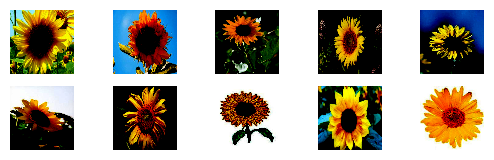

<Figure size 1200x800 with 0 Axes>

In [9]:
show_images(data_lowres[0:10])

Use MinMaxScaler to scale the dataset

In [11]:
# Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))
# Select images that we want to use fro model trainng
data=data_lowres.copy()
print("Original shape of the data: ", data.shape)
# Reshape array
data=data.reshape(-1, 1)
print("Reshaped data: ", data.shape)
# Fit the scaler
scaler.fit(data)
# Scale the array
data=scaler.transform(data)
# Reshape back to the original shape
data=data.reshape(data_lowres.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (85, 64, 64, 3)
Reshaped data:  (1044480, 1)
Shape of the scaled array:  (85, 64, 64, 3)


### 3. Build Deep Convolutional Generative Adversarial Networks

A DCGAN is a direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector, zz, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image. In the paper, the authors also give some tips about how to setup the optimizers, how to calculate the loss functions, and how to initialize the model weights, all of which will be explained in the coming sections.

![DCGAN](./DCGAN.png)

#### 3.1 Define Generator model

In [12]:
def generator(latent_dim):
    model = Sequential(name="Generator") # Model
    
    # Hidden Layer 1: Start with 8 x 8 image
    n_nodes = 8 * 8 * 128 # number of nodes in the first hidden layer
    model.add(Dense(n_nodes, input_dim=latent_dim, name='Generator-Hidden-Layer-1'))
    model.add(Reshape((8, 8, 128), name='Generator-Hidden-Layer-Reshape-1'))
    
    # Hidden Layer 2: Upsample to 16 x 16
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-2'))
                              
    # Hidden Layer 3: Upsample to 32 x 32
    model.add(Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-3'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-3'))
    
    # Hidden Layer 4: Upsample to 64 x 64
    model.add(Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-4'))
    model.add(ReLU(name='Generator-Hidden-Layer-Activation-4'))
    
    # Output Layer (Note, we use 3 filters because we have 3 channels for a color image. Grayscale would have only 1 channel)
    model.add(Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'))
    return model

# Instantiate
latent_dim=100 # Our latent space has 100 dimensions. We can change it to any number
gen_model = generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='generator_structure.png')

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 8192)             827392    
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-Resh  (None, 8, 8, 128)        0         
 ape-1 (Reshape)                                                 
                                                                 
 Generator-Hidden-Layer-2 (C  (None, 16, 16, 128)      262272    
 onv2DTranspose)                                                 
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-Hidden-Layer-3 (C  (None, 32, 32, 256)      52

2022-12-02 22:09:35.280396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 3.2 Define a Discriminator model

In [13]:
def discriminator(in_shape=(64,64,3)):
    model = Sequential(name="Discriminator") # Model
    
    # Hidden Layer 1
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-1'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1'))
    
    # Hidden Layer 2
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-2'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2'))
    
    # Hidden Layer 3
    model.add(Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=in_shape, name='Discriminator-Hidden-Layer-3'))
    model.add(LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3'))
    
    # Flatten and Output Layers
    model.add(Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
    model.add(Dropout(0.3, name='Discriminator-Flatten-Layer-Dropout')) # Randomly drop some connections for better generalization
    model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='discriminator_structure.png')

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       3136      
 1 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 32, 32, 64)       0         
 Activation-1 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      131200    
 2 (Conv2D)                                                      
                                                                 
 Discriminator-Hidden-Layer-  (None, 16, 16, 128)      0         
 Activation-2 (LeakyReLU)                                        
                                                                 
 Discriminator-Hidden-Layer-  (None, 8, 8, 128)      

#### 3.3 Combine Generator and Discriminator models into trainable GAN

In [14]:
def def_gan(generator, discriminator):
    
    # We don't want to train the weights of discriminator at this stage. Hence, make it not trainable
    discriminator.trainable = False
    
    # Combine
    model = Sequential(name="DCGAN") # GAN Model
    model.add(generator) # Add Generator
    model.add(discriminator) # Add Disriminator
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

# Instantiate
gan_model = def_gan(gen_model, dis_model)

# Show model summary and plot model diagram
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400) #, to_file='dcgan_structure.png')

Model: "DCGAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         3750275   
                                                                 
 Discriminator (Sequential)  (None, 1)                 404801    
                                                                 
Total params: 4,155,076
Trainable params: 3,750,275
Non-trainable params: 404,801
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 4 Build function

#### 4.1 Sample real images

In [15]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))

    return X, y

#### 4.2 Sample the latent space, Generate points in the latent space to use as inputs for the generator

In [16]:
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input

#### 4.3  Generate fake images with the generator model together with class labels

In [17]:
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y

### 5 Model Performance Evaluation

 Show Discriminator model accuracy and plot real vs. fake (generated) comparison

In [18]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

### 6. Function to Train DCGAN model (generator and discriminator)

In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

### 7. Train the model and display the results

1/1 [==============================] - 1s 672ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.5109081268310547
Generator Loss:  1.0828735828399658
2/2 [==============================] - 3s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.800000011920929
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


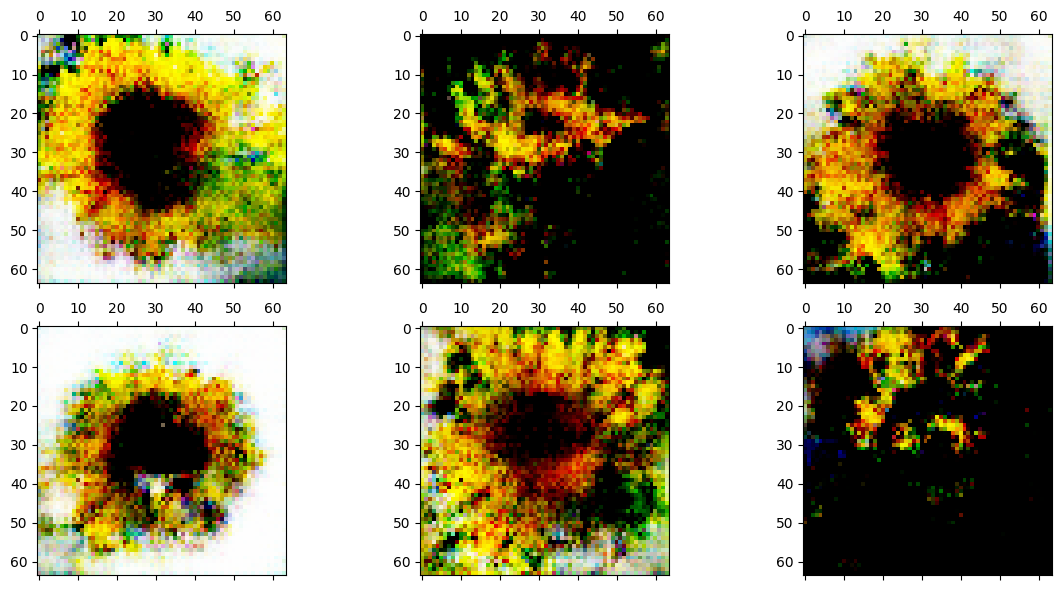

1/1 [==============================] - 1s 727ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.41307544708251953
Generator Loss:  1.411651849746704
2/2 [==============================] - 2s 789ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6399999856948853
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


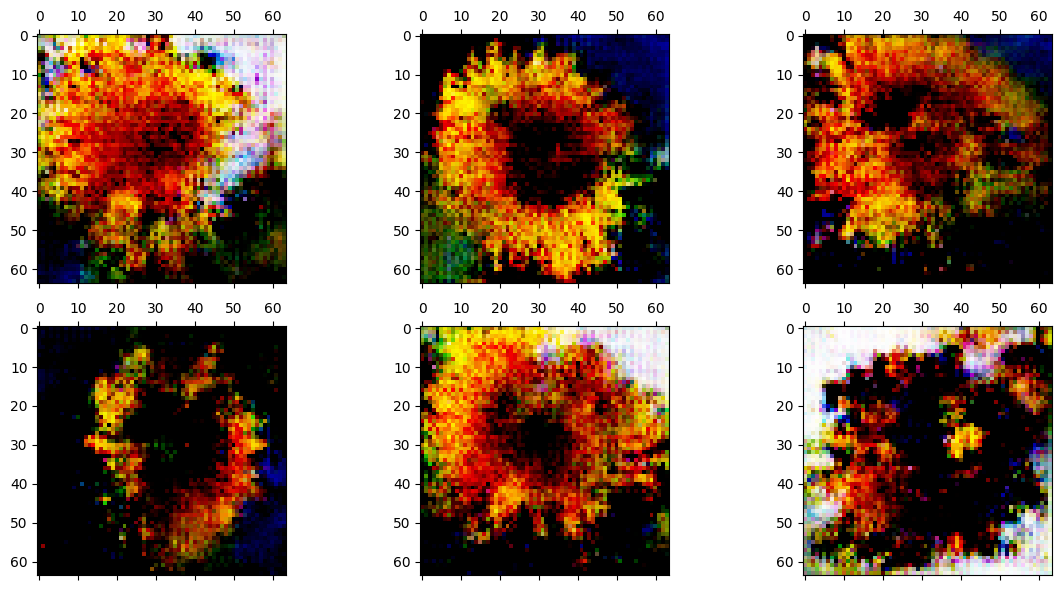

1/1 [==============================] - 1s 653ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.42456626892089844
Generator Loss:  1.4129221439361572
2/2 [==============================] - 2s 732ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  0.9399999976158142


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


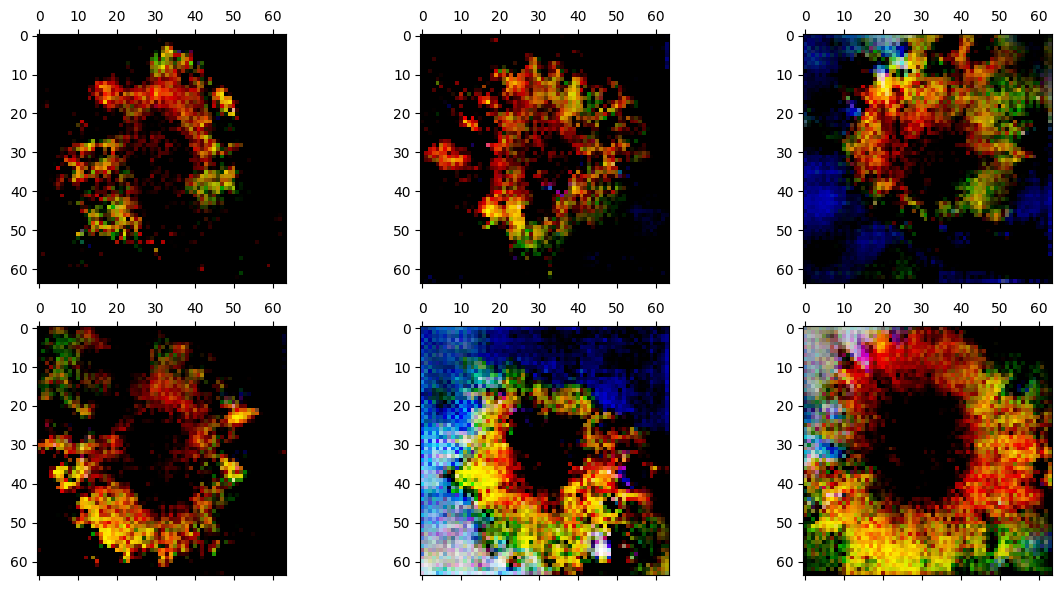

1/1 [==============================] - 1s 632ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.445777952671051
Generator Loss:  1.5663238763809204
2/2 [==============================] - 2s 741ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


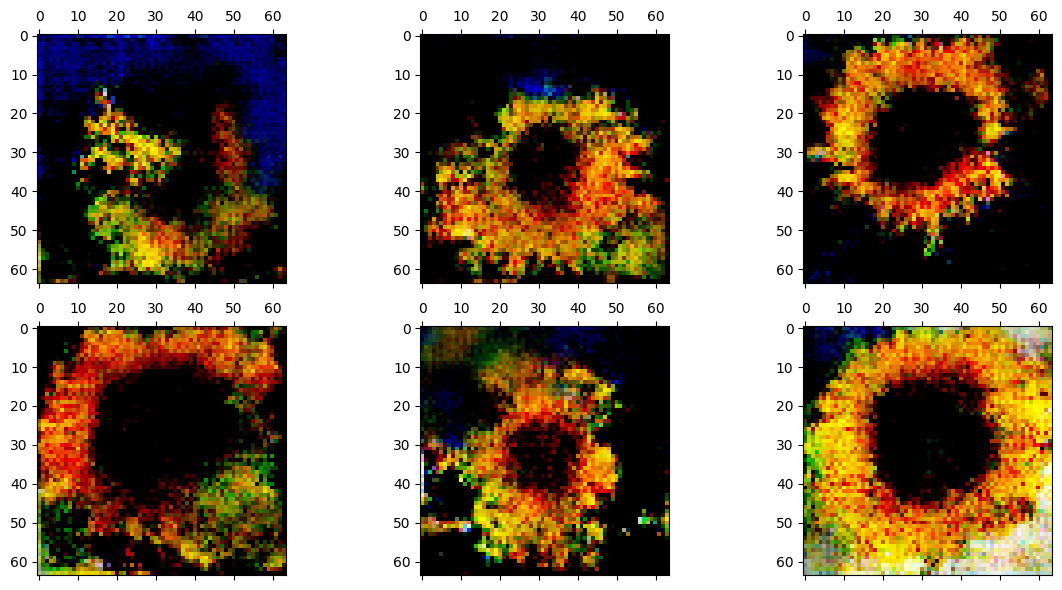

1/1 [==============================] - 1s 706ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.42754679918289185
Generator Loss:  1.200757622718811
2/2 [==============================] - 2s 678ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


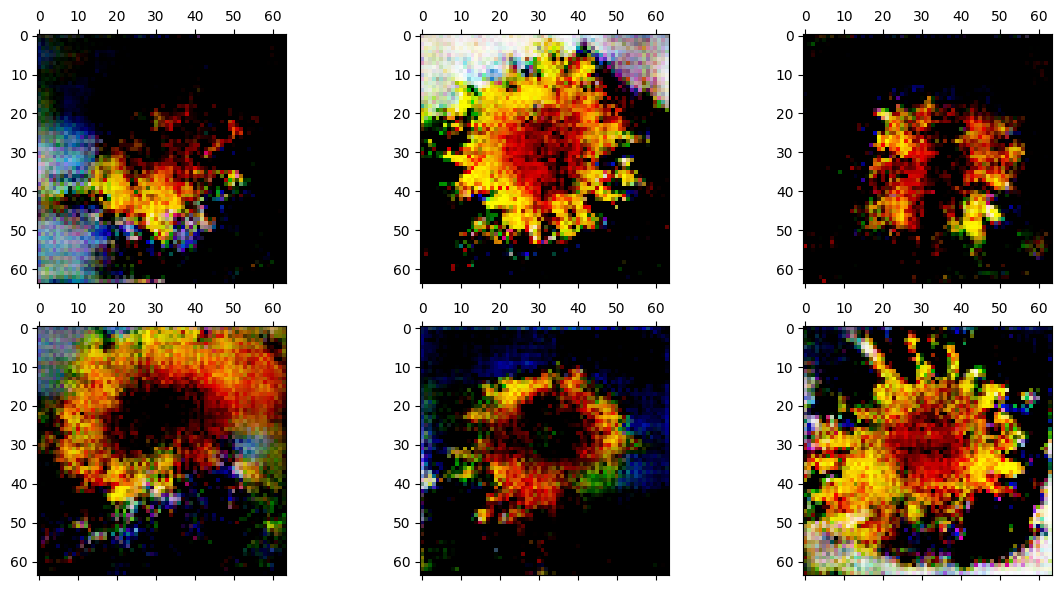

1/1 [==============================] - 1s 655ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.24544517695903778
Generator Loss:  1.7622267007827759
2/2 [==============================] - 2s 707ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


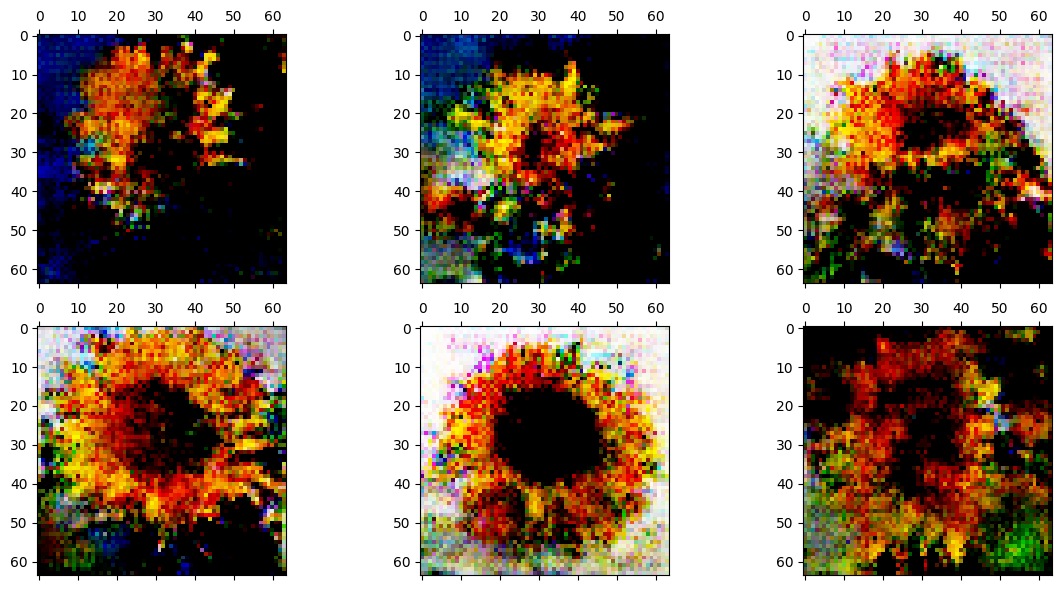

1/1 [==============================] - 1s 1s/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.25300535559654236
Generator Loss:  1.6778240203857422
2/2 [==============================] - 2s 719ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


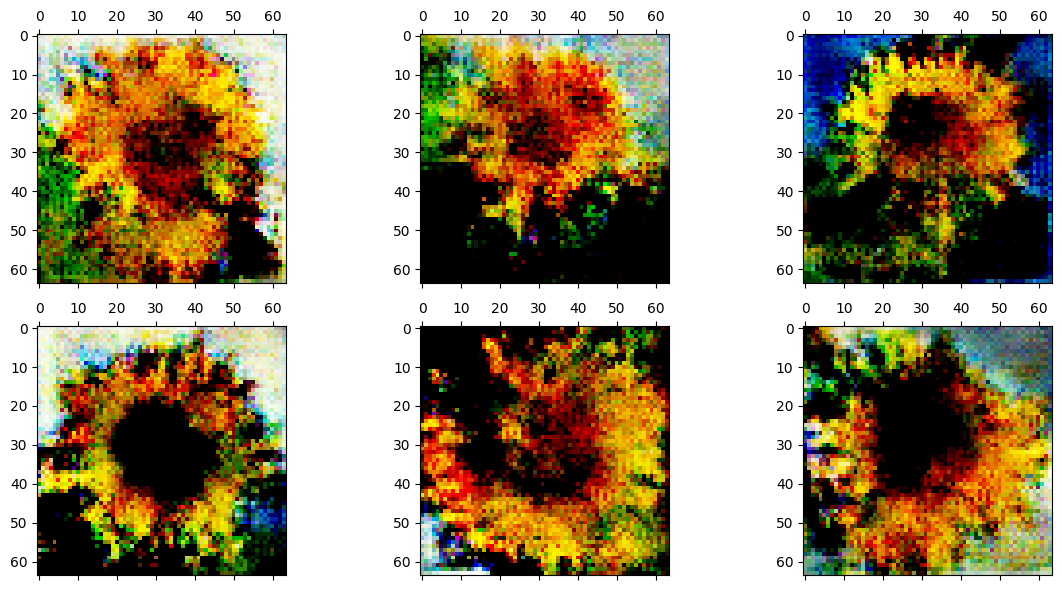

1/1 [==============================] - 1s 631ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.24806472659111023
Generator Loss:  2.231950521469116
2/2 [==============================] - 2s 685ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9599999785423279
Discriminator Accuracy on FAKE (generated) images:  1.0


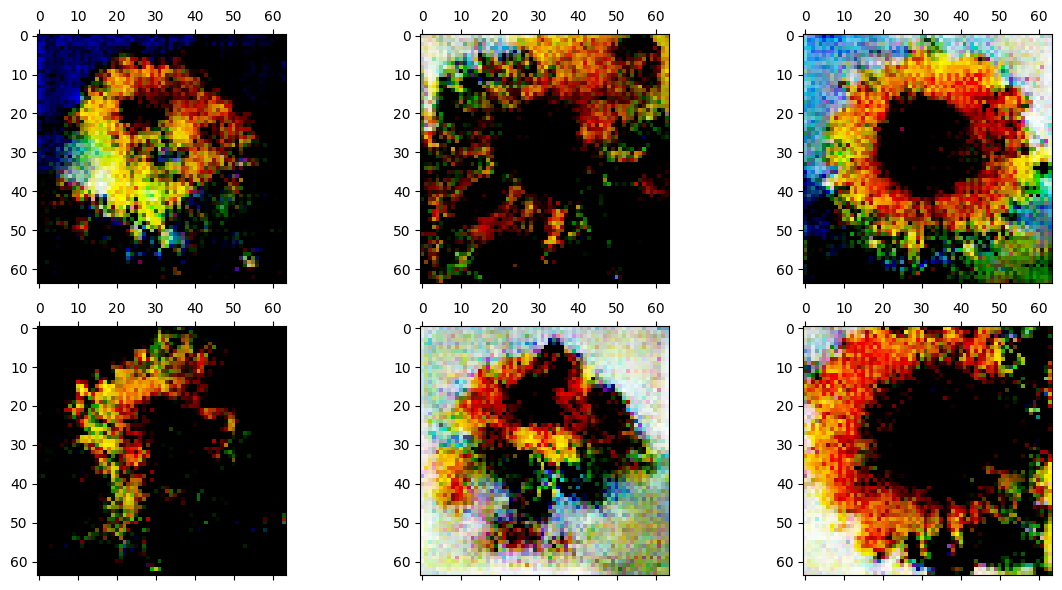

1/1 [==============================] - 1s 697ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.21785670518875122
Generator Loss:  2.5446066856384277
2/2 [==============================] - 2s 803ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


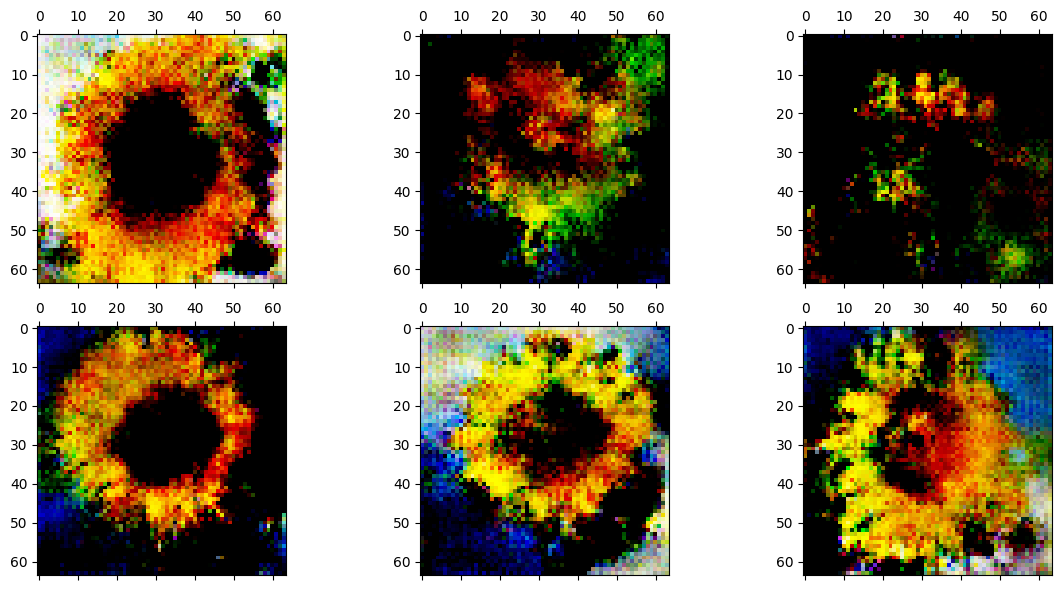

1/1 [==============================] - 1s 741ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.21660727262496948
Generator Loss:  1.7438210248947144
2/2 [==============================] - 2s 796ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.8799999952316284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


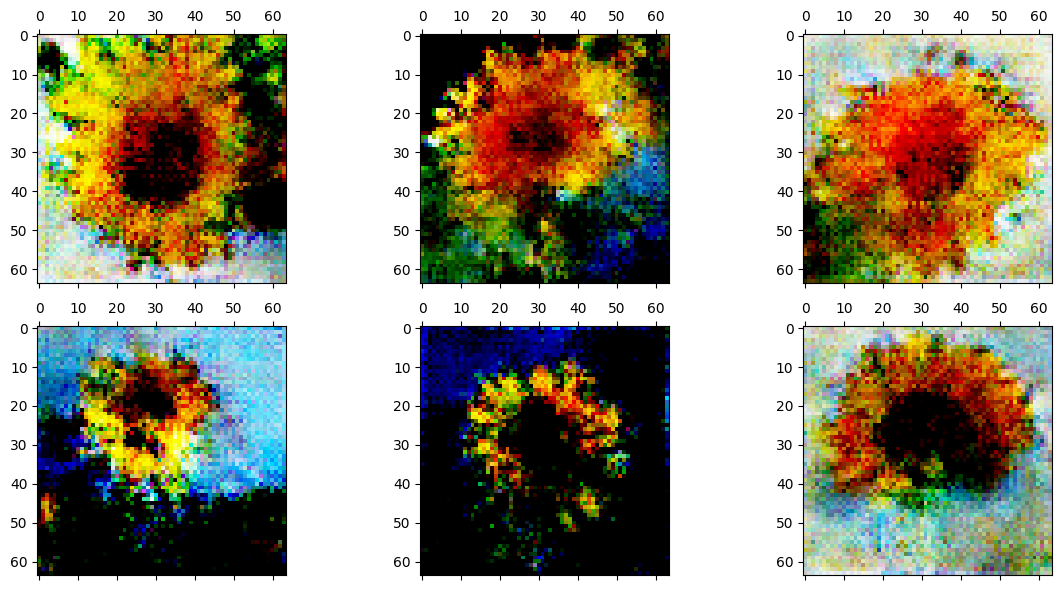

1/1 [==============================] - 1s 635ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.16922461986541748
Generator Loss:  2.2711904048919678
2/2 [==============================] - 2s 678ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.9599999785423279


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


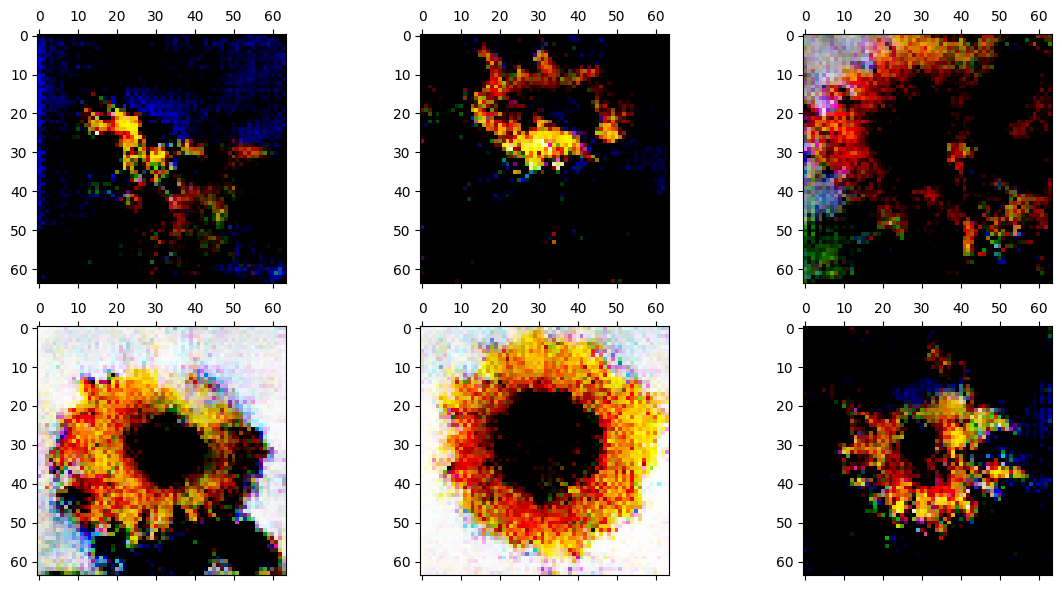

In [28]:
# Train DCGAN model with 1000 epochs
train(gen_model, dis_model, gan_model, data, latent_dim)

1/1 [==============================] - 1s 1s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.5501241683959961
Generator Loss:  0.8927092552185059
2/2 [==============================] - 3s 946ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.8399999737739563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


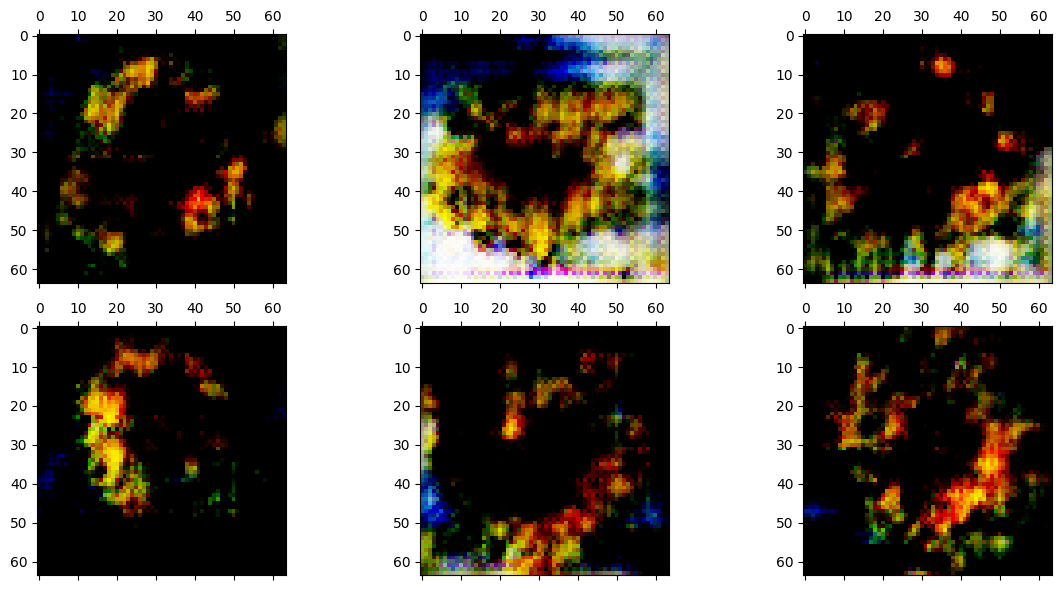

1/1 [==============================] - 1s 659ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  0.6236556768417358
Generator Loss:  0.8075892925262451
2/2 [==============================] - 2s 720ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8399999737739563
Discriminator Accuracy on FAKE (generated) images:  0.3400000035762787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


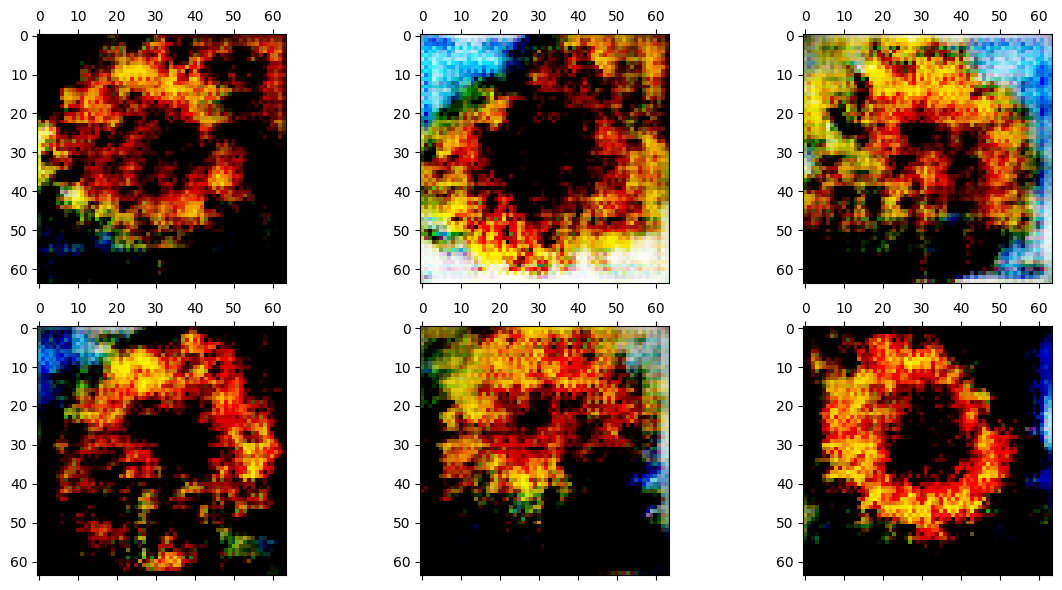

1/1 [==============================] - 1s 637ms/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.5350264310836792
Generator Loss:  0.8854470252990723
2/2 [==============================] - 2s 695ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.699999988079071
Discriminator Accuracy on FAKE (generated) images:  0.6000000238418579


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


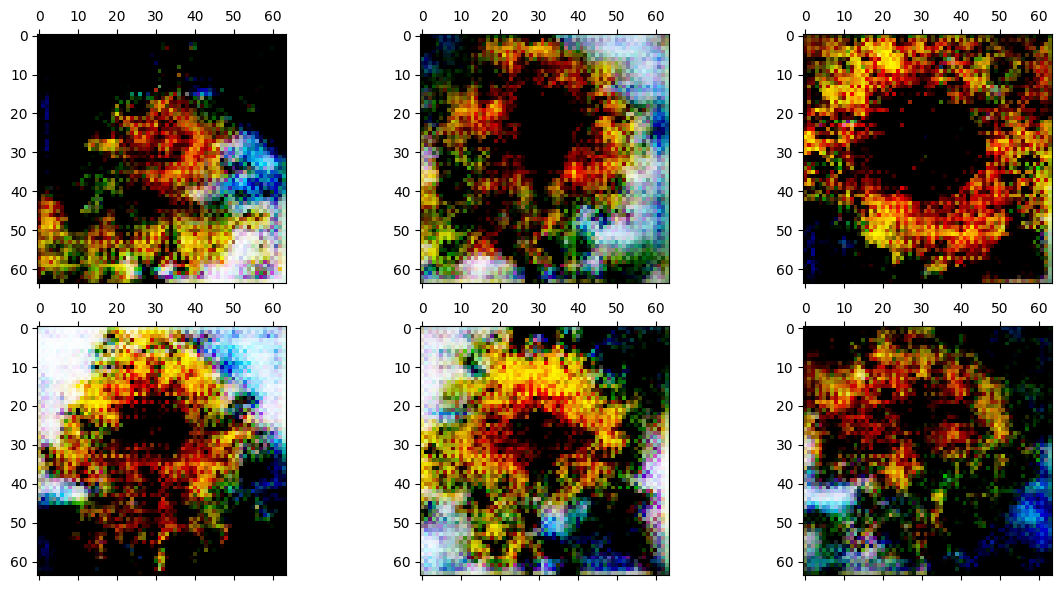

1/1 [==============================] - 1s 664ms/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.6477162837982178
Generator Loss:  0.8868229985237122
2/2 [==============================] - 2s 785ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6800000071525574
Discriminator Accuracy on FAKE (generated) images:  0.699999988079071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


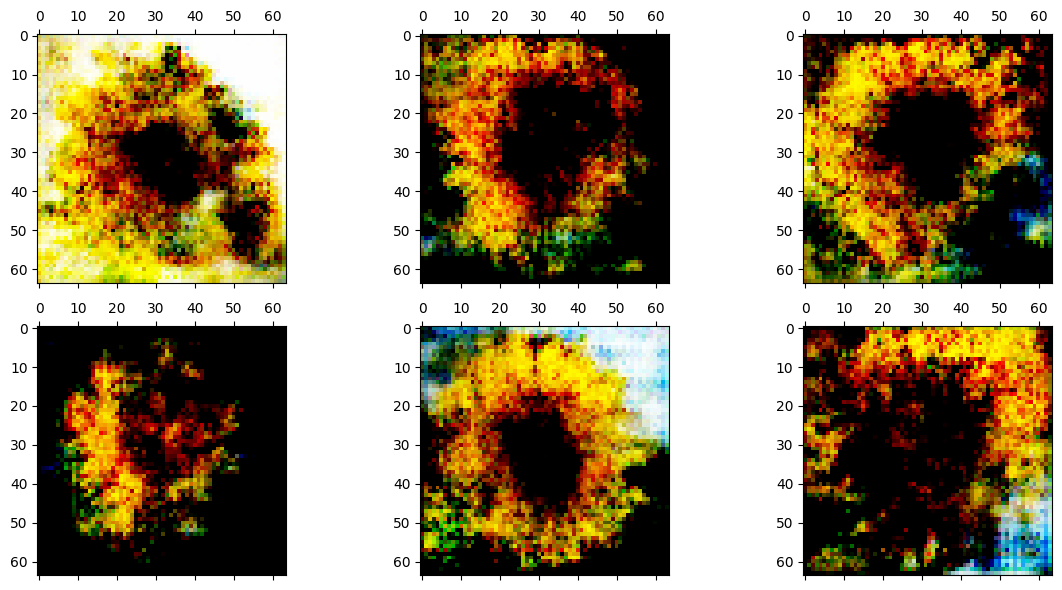

1/1 [==============================] - 1s 612ms/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.638248860836029
Generator Loss:  0.8380289077758789
2/2 [==============================] - 2s 682ms/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7799999713897705
Discriminator Accuracy on FAKE (generated) images:  0.699999988079071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


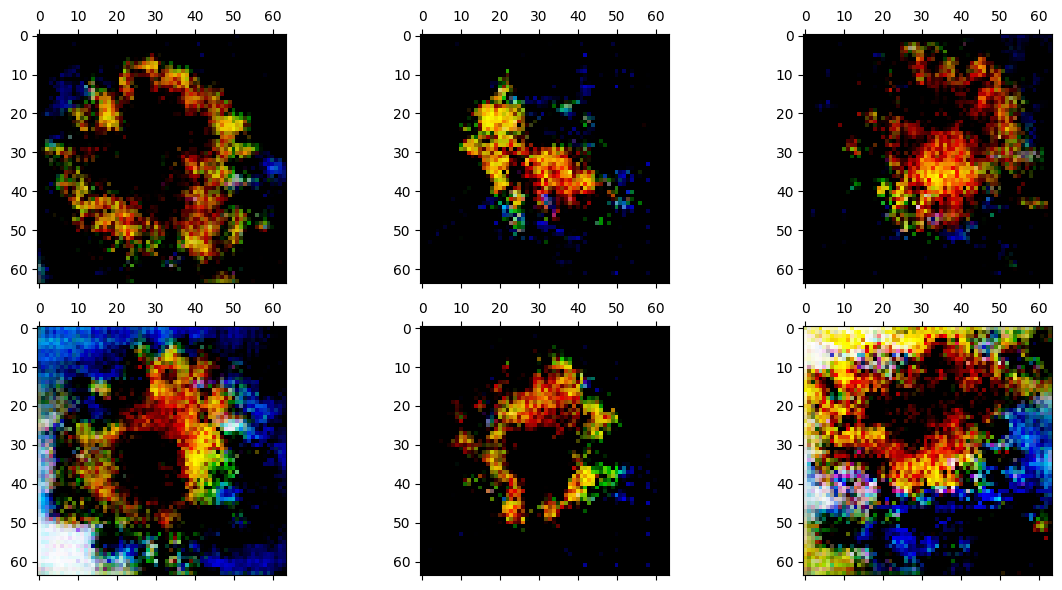

1/1 [==============================] - 1s 752ms/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.614319384098053
Generator Loss:  0.7916140556335449
2/2 [==============================] - 2s 661ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8999999761581421
Discriminator Accuracy on FAKE (generated) images:  0.7200000286102295


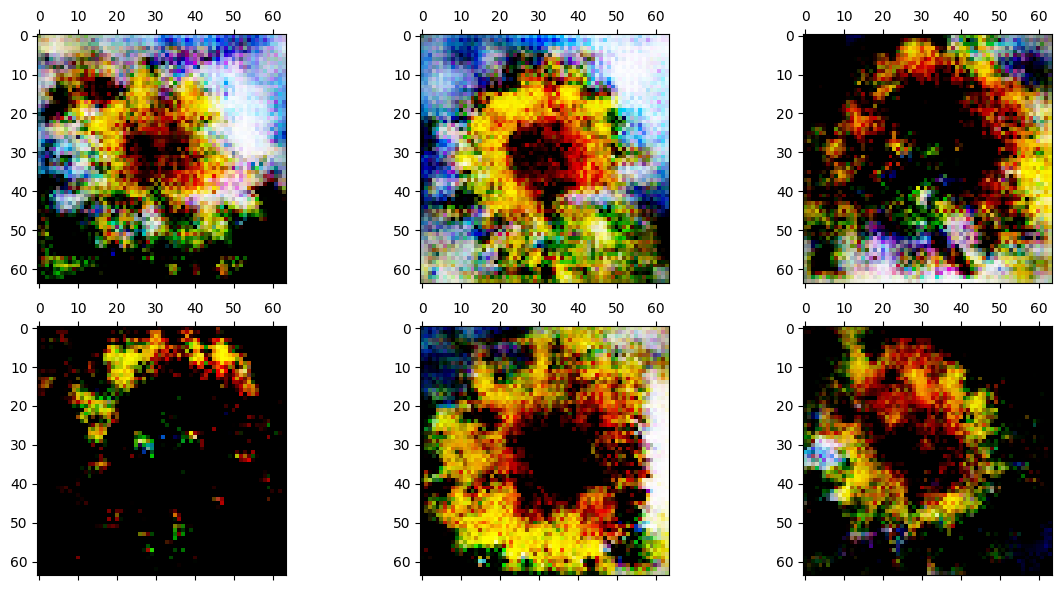

1/1 [==============================] - 1s 602ms/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.534224271774292
Generator Loss:  0.9107422232627869
2/2 [==============================] - 2s 639ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


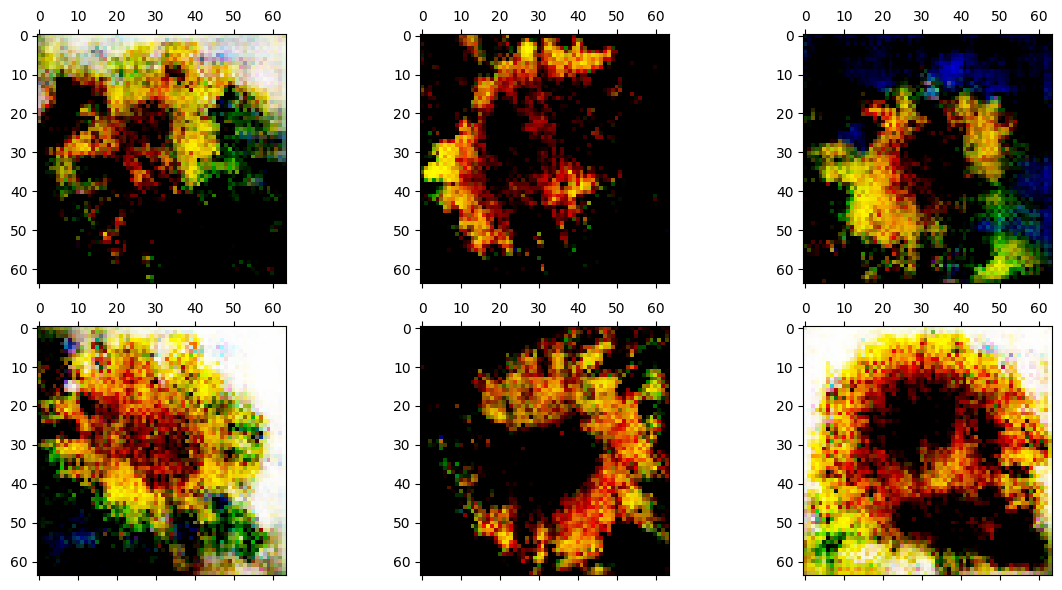

1/1 [==============================] - 1s 619ms/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.532190203666687
Generator Loss:  1.271742343902588
2/2 [==============================] - 2s 681ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.5
Discriminator Accuracy on FAKE (generated) images:  1.0


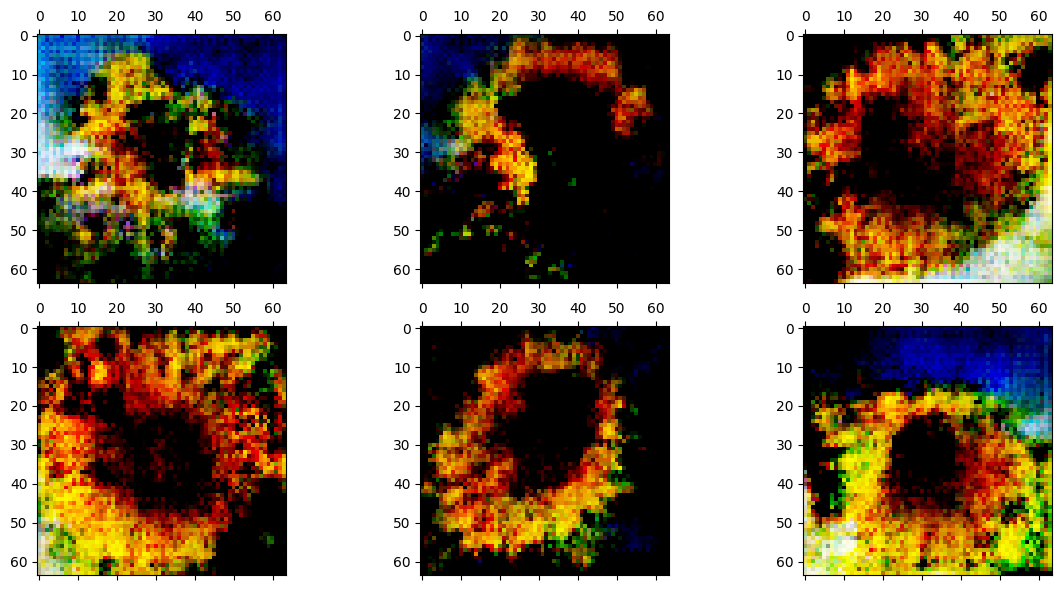

1/1 [==============================] - 1s 617ms/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.5264292359352112
Generator Loss:  0.8080058097839355
2/2 [==============================] - 2s 668ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.6800000071525574


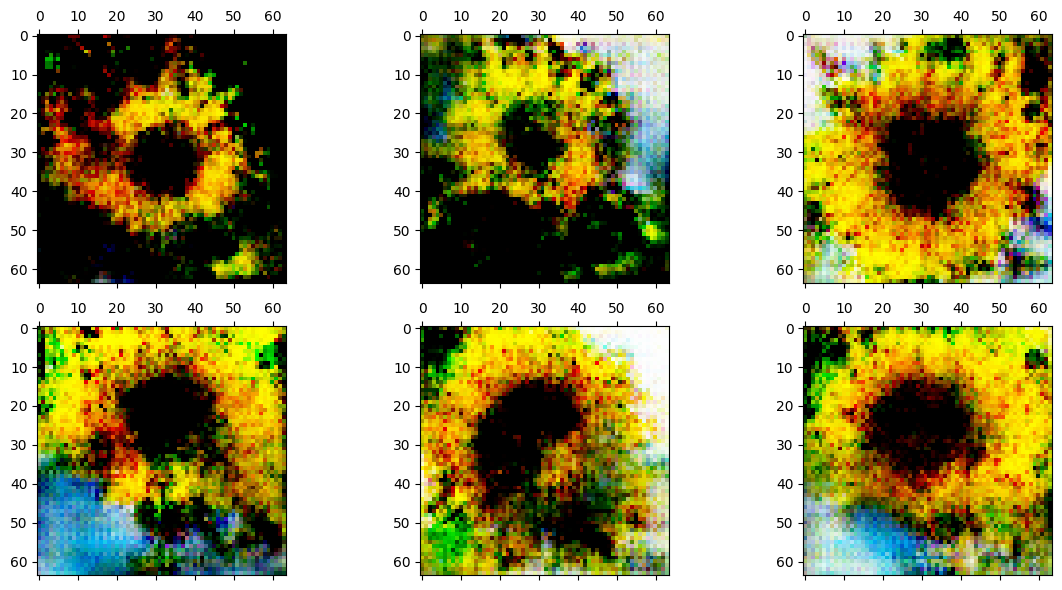

1/1 [==============================] - 1s 610ms/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.493302583694458
Generator Loss:  1.2031075954437256
2/2 [==============================] - 2s 649ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.8600000143051147


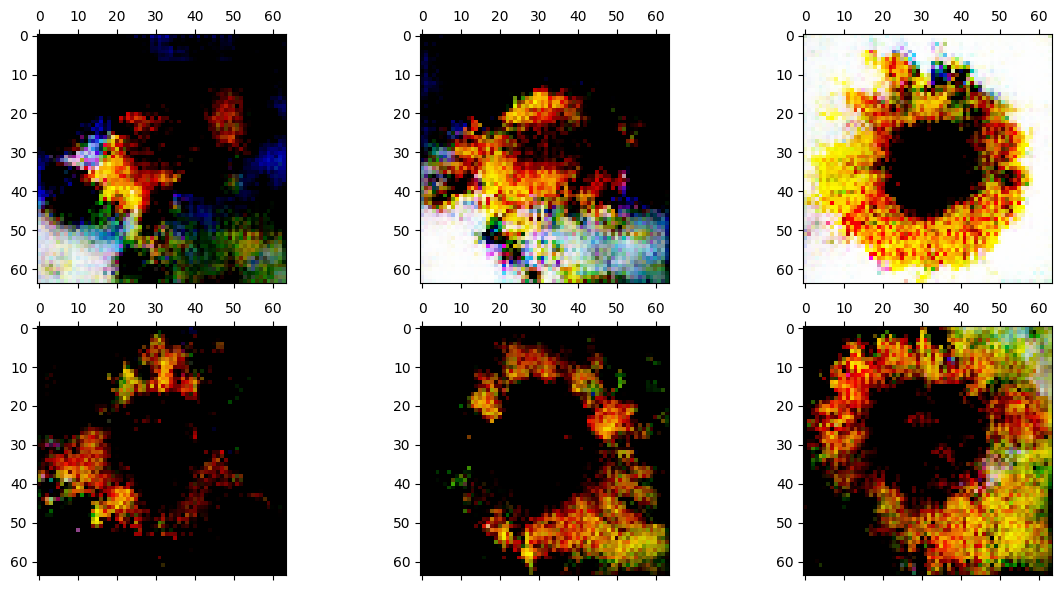

1/1 [==============================] - 1s 617ms/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.5641588568687439
Generator Loss:  1.4223119020462036
2/2 [==============================] - 2s 659ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6000000238418579
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


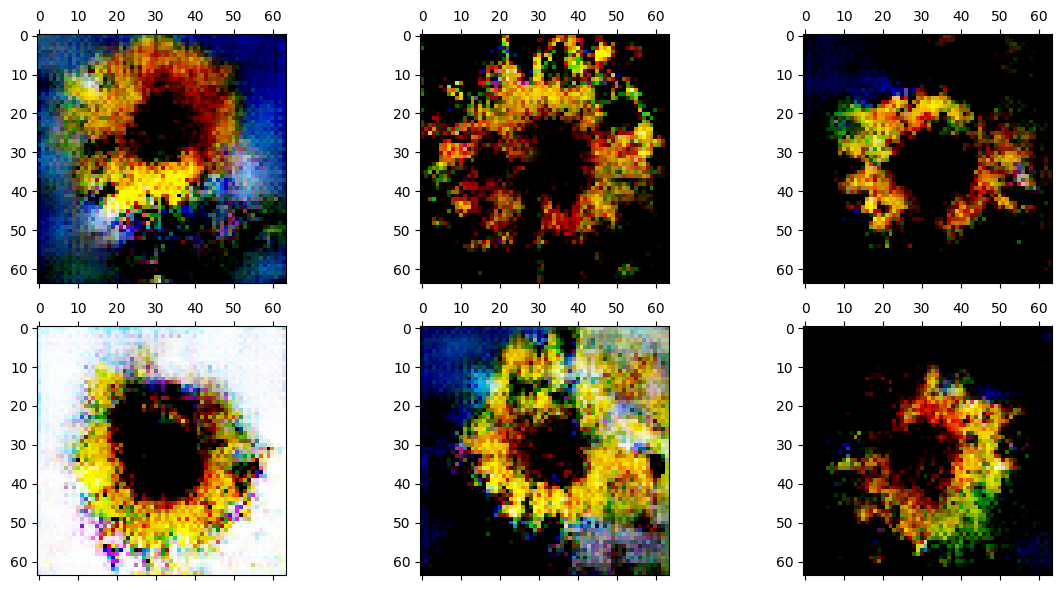

In [21]:
# Continue training DCGAN model for another 1000 epochs
train(gen_model, dis_model, gan_model, data, latent_dim)

In [22]:
# Save the current versions of the models (After 2k epcohs)
gen_model.save(main_dir+"/Assignment 4_Wei Chen/data/models/Generator.h5")
dis_model.save(main_dir+"/Assignment 4_Wei Chen/data/models/Discriminator.h5")
gan_model.save(main_dir+"/Assignment 4_Wei Chen/data/models/GAN.h5")

---

### 8. Create Images with Generator 

In [23]:
def performance_eval(epoch, generator, discriminator, dataset, latent_dim, n=45):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("Epoch number: ", epoch)
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Create a 2D scatter plot to show real and fake (generated) data points
    # Display 20 fake images
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(8, 5, sharey=False, tight_layout=True, figsize=(48,48), facecolor='white')
    k=0
    for i in range(0,8):
        for j in range(0,5):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

2/2 [==============================] - 2s 455ms/step
Epoch number:  0
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.9777777791023254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

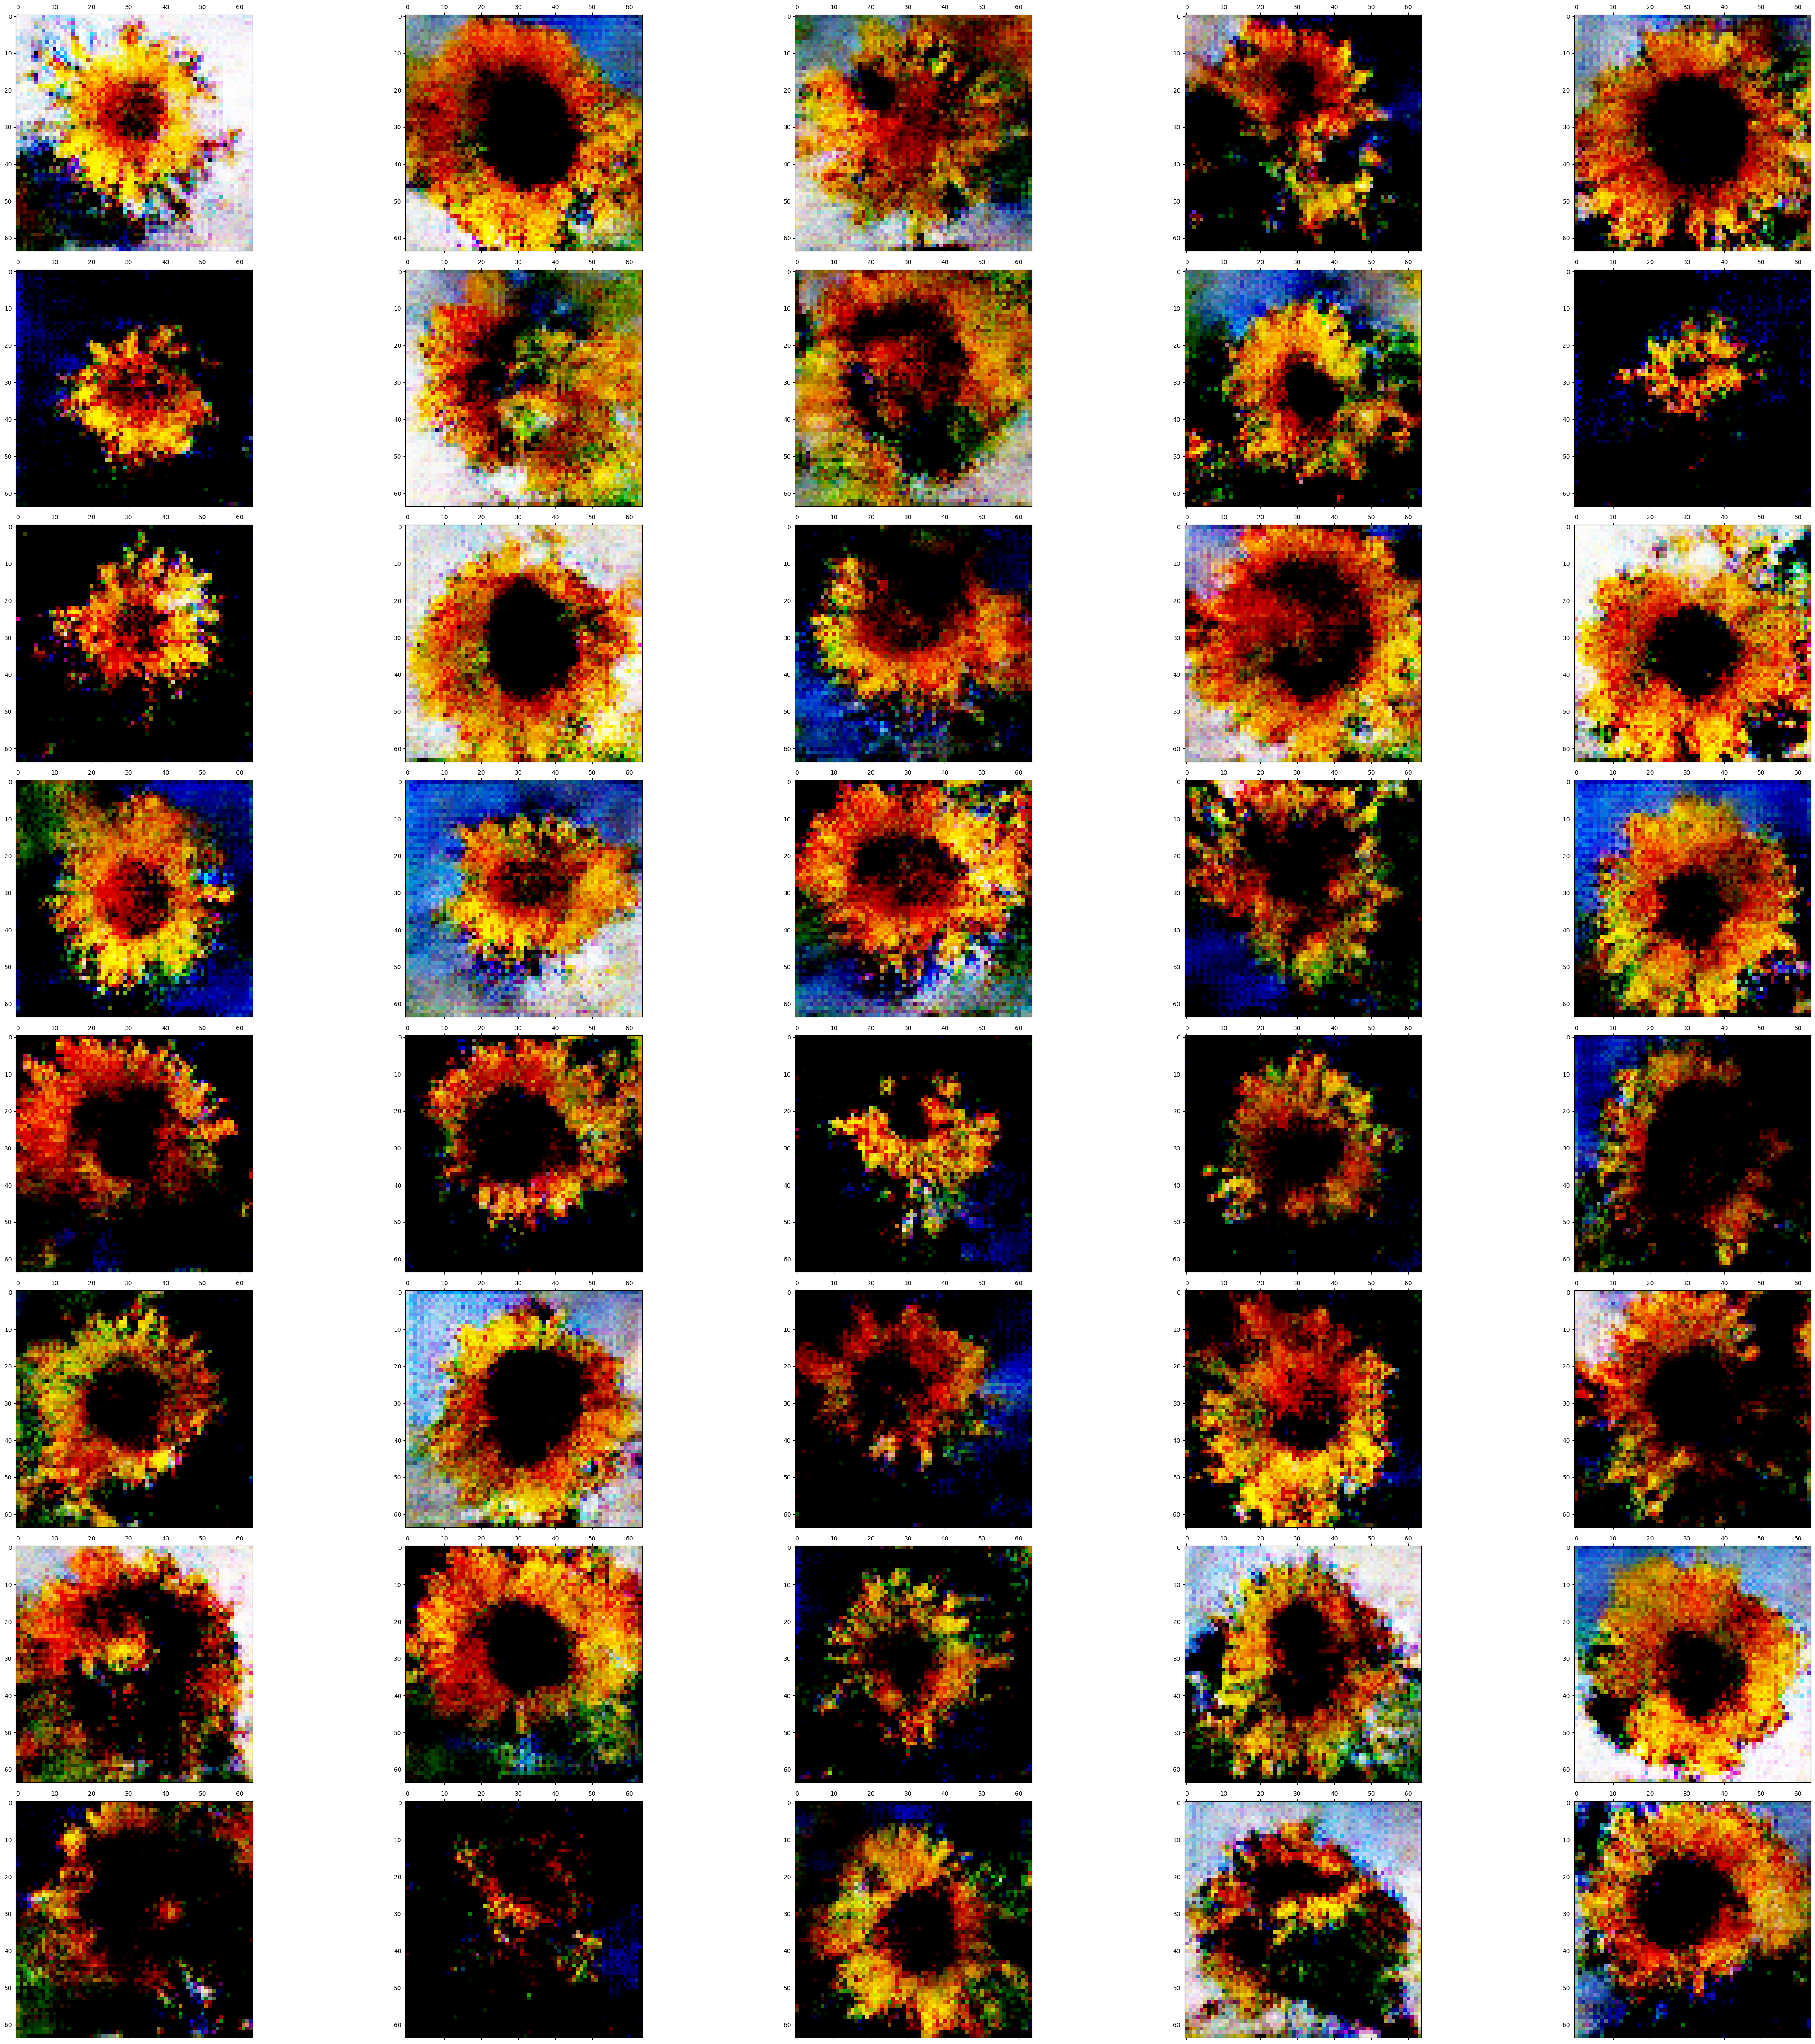

In [29]:
# After 2K epochs
performance_eval(0, gen_model, dis_model, data, 100)

### 9. Conclusion

From the results above we can tell that, A sample output of the trained generator on sunflower images is shown above. We can observe the artifacts in the generated images which is one of the limitations of the DCGAN architecture. For better results, a number of strategies could be employed, changing the loss function, changing the normalization to better methods, spectral normalization, changing the number of features/layers in the middle network.The less the  latenet vector, sunflowers will be brighter and clearer. If we train more epoches, the sunflower will be more detailed, But we will need more time too.

![Latent](./Latent.png)

For the best trade-off between compression and quality, we need to balance the architecture and need more time to train.

### Generate random Image

In [32]:
# Generate an image of a sunflower using random latent vector
x_fake, y_fake = fake_samples(gen_model, 100, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans=x_fake.reshape(-1, 1)
x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 3)

1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


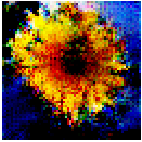

In [33]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16,9), dpi=20)
ax.matshow(x_fake_inv_trans)
plt.axis('off')
plt.show()

In [39]:
# Generate an image of a sunflower using random latent vector
x_fake, y_fake = fake_samples(gen_model, 100, 1)

# Shape and inverse transpose the generated image
x_fake_inv_trans=x_fake.reshape(-1, 1)
x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
x_fake_inv_trans=x_fake_inv_trans.reshape(64, 64, 3)

1/1 [==============================] - 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


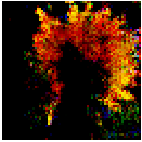

In [40]:
# Show the generated image
fig, ax = plt.subplots(figsize=(16,9), dpi=20)
ax.matshow(x_fake_inv_trans)
plt.axis('off')
plt.show()

## Reference

[1] Dataset https://data.caltech.edu/records/mzrjq-6wc02

[2] DCGAN TUTORIAL https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

[3] LATENT SPACES (Part-3): A Practical Introduction to Deep Convolutional Generative Adversarial Network (DCGAN) https://medium.com/mlearning-ai/latent-spaces-part-3-a-practical-introduction-to-deep-convolutional-generative-adversarial-8c6169bbf9b0

[4] DCGANs (Deep Convolutional Generative Adversarial Networks) https://towardsdatascience.com/dcgans-deep-convolutional-generative-adversarial-networks-c7f392c2c8f8

[5] GAN based Generation and Discrimination https://www.kaggle.com/code/blurredmachine/gan-based-generation-and-discrimination

##  Licenses

All licenses in this repository are copyrighted by their respective authors.

------------------------------------------------------------------------------

@author: Wei Chen (chen.wei6@northeastern.edu)

The person who associated a work with this deed has dedicated the work to the
public domain by waiving all of his or her rights to the work worldwide under
copyright law, including all related and neighboring rights,
to the extent allowed by law.

You can copy, modify, distribute and perform the work, even for commercial
purposes, all without asking permission. 